# Imports

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
data = pd.read_csv("../raw_data/train.csv")
data_test = pd.read_csv("../raw_data/test.csv")

In [3]:
data.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


# Data exploration

In [4]:
X_train = data.drop(columns=['loan_paid_back', 'id'])
y_train = data['loan_paid_back']
X_train.head()

numeric_cols = X_train.select_dtypes(include="number").columns

numeric_features = list(numeric_cols)
categorical_features = list(X_train.drop(columns=numeric_cols))

In [5]:
data.isnull().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [6]:
data.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [7]:
max_income = data.annual_income.max()
print("max income:",max_income)
min_income = data.annual_income.min()
print("min income:",min_income)
#Use min_max scaler for annual_income


max income: 393381.74
min income: 6002.43


In [8]:
X_train['grade_subgrade'].unique()

array(['C3', 'D3', 'C5', 'F1', 'D1', 'D5', 'C2', 'C1', 'F5', 'D4', 'C4',
       'D2', 'E5', 'B1', 'B2', 'F4', 'A4', 'E1', 'F2', 'B4', 'E4', 'B3',
       'E3', 'B5', 'E2', 'F3', 'A5', 'A3', 'A1', 'A2'], dtype=object)

In [9]:
y_train.value_counts(normalize=True)

loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

In [10]:
data[numeric_features].describe()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345
std,26711.942078,0.068573,55.424956,6926.530568,2.008959
min,6002.430000,0.011000,395.000000,500.090000,3.200000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000
max,393381.740000,0.627000,849.000000,48959.950000,20.990000


array([[<Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'debt_to_income_ratio'}>],
       [<Axes: title={'center': 'credit_score'}>,
        <Axes: title={'center': 'loan_amount'}>],
       [<Axes: title={'center': 'interest_rate'}>, <Axes: >]],
      dtype=object)

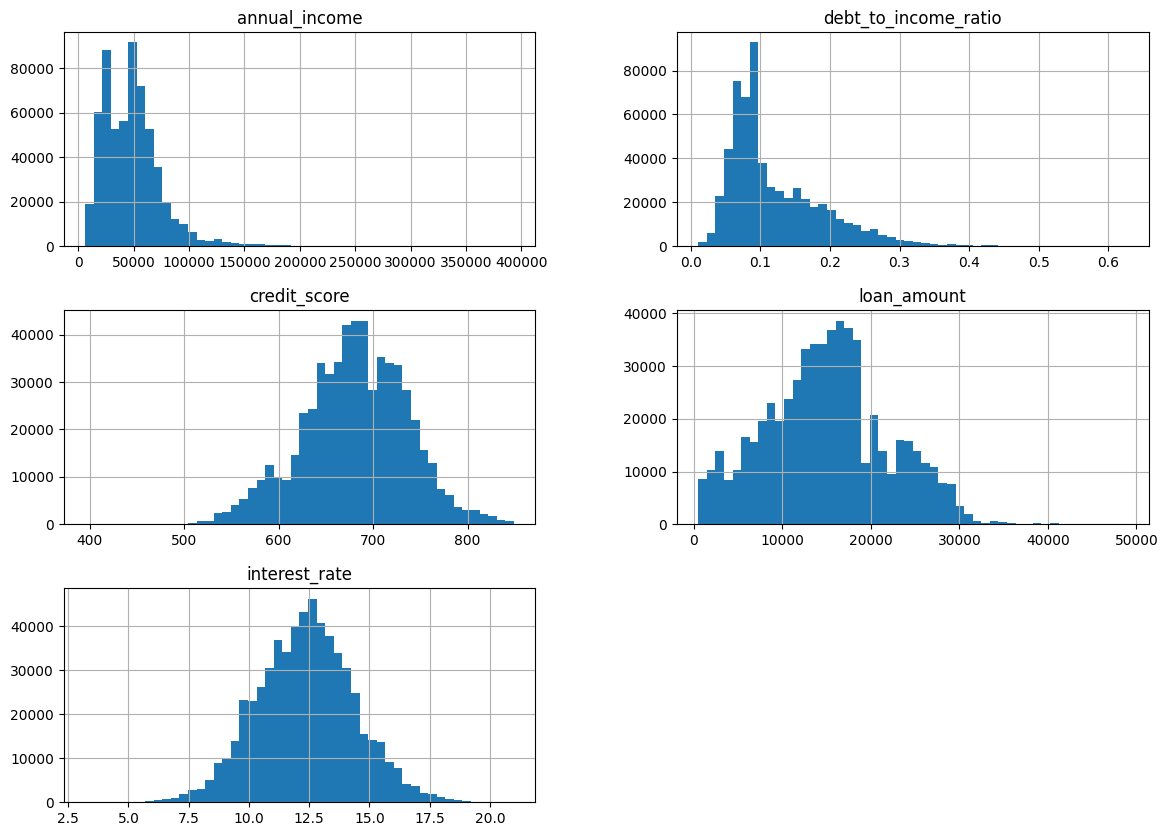

In [11]:
data[numeric_features].hist(bins=50, figsize=(14, 10))

In [12]:
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    ratio = len(outliers) / len(data)

    print(f"{col}: {ratio:.2%} outliers")

annual_income: 2.68% outliers
debt_to_income_ratio: 2.96% outliers
credit_score: 0.99% outliers
loan_amount: 0.49% outliers
interest_rate: 0.86% outliers


([0, 1, 2, 3, 4],
 [Text(0, 0, 'annual_income'),
  Text(1, 0, 'debt_to_income_ratio'),
  Text(2, 0, 'credit_score'),
  Text(3, 0, 'loan_amount'),
  Text(4, 0, 'interest_rate')])

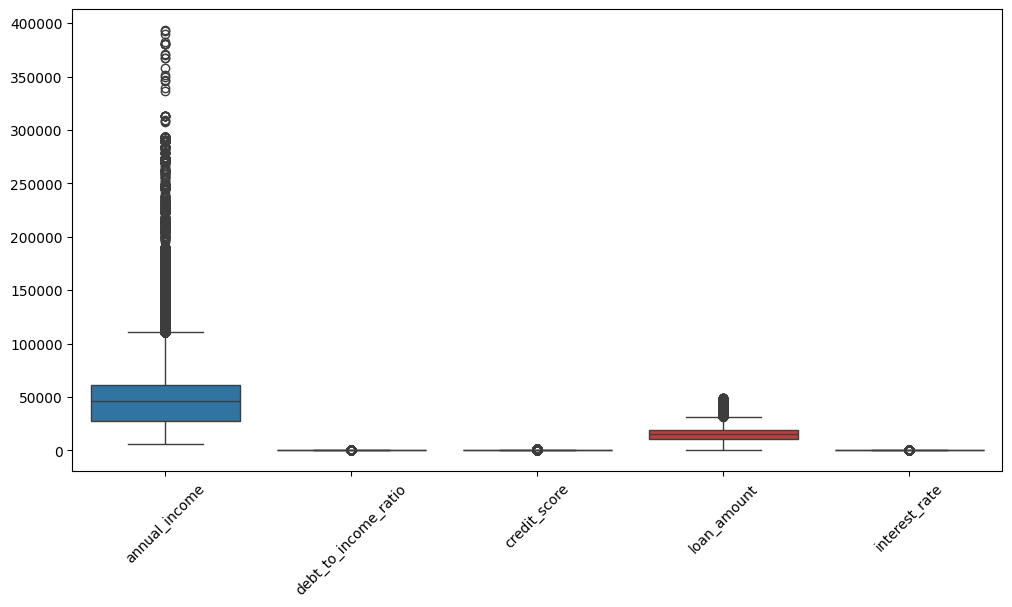

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data[numeric_features])
plt.xticks(rotation=45)

In [14]:
for col in categorical_features:
    print(data[col].value_counts(normalize=True))
    print("\n")

gender
Female    0.515451
Male      0.478273
Other     0.006276
Name: proportion, dtype: float64


marital_status
Single      0.486273
Married     0.466737
Divorced    0.035879
Widowed     0.011111
Name: proportion, dtype: float64


education_level
Bachelor's     0.470722
High School    0.309081
Master's       0.156731
Other          0.044911
PhD            0.018556
Name: proportion, dtype: float64


employment_status
Employed         0.758669
Unemployed       0.105195
Self-employed    0.088351
Retired          0.027699
Student          0.020086
Name: proportion, dtype: float64


loan_purpose
Debt consolidation    0.546630
Other                 0.107533
Car                   0.097826
Home                  0.074273
Education             0.061686
Business              0.059433
Medical               0.038394
Vacation              0.014224
Name: proportion, dtype: float64


grade_subgrade
C3    0.098814
C4    0.094205
C2    0.091656
C1    0.089838
C5    0.089760
D1    0.062339
D3    0.0617

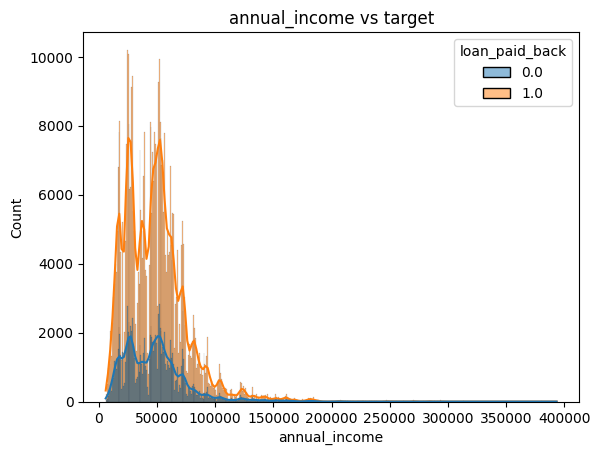

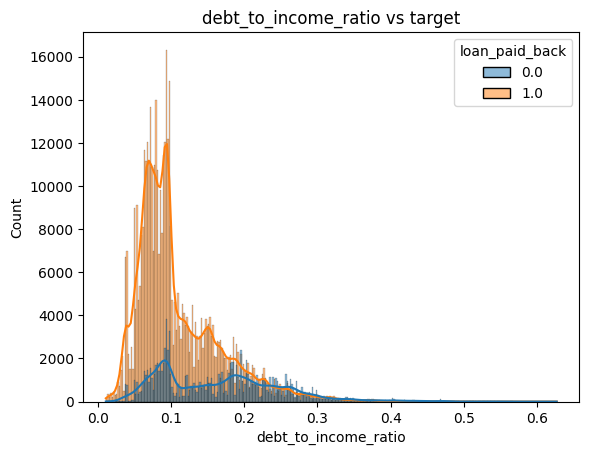

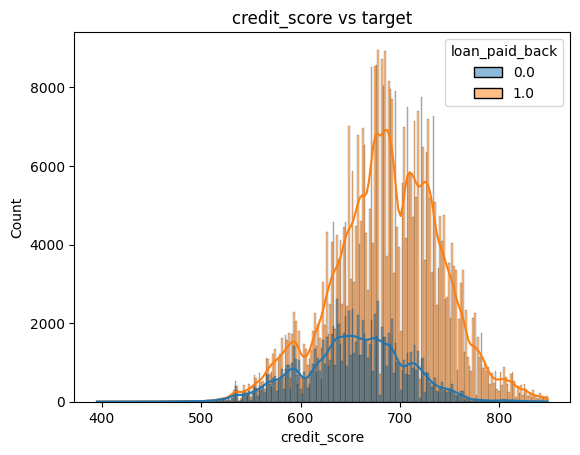

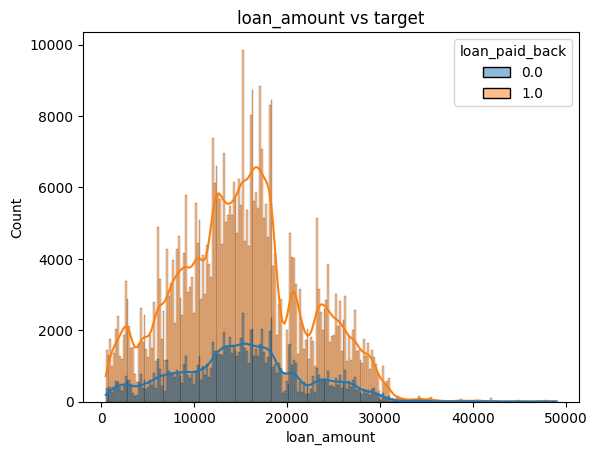

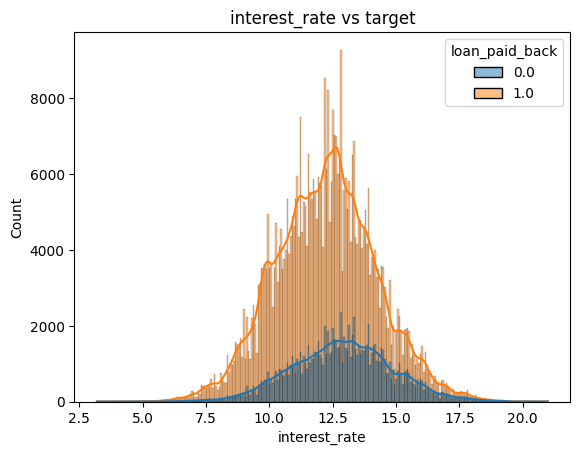

In [15]:
import seaborn as sns

for col in numeric_features:
    sns.histplot(data, x=col, hue="loan_paid_back", kde=True)
    plt.title(f"{col} vs target")
    plt.show()

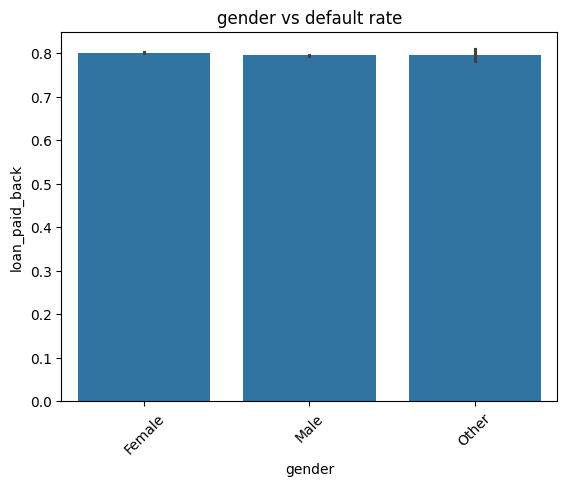

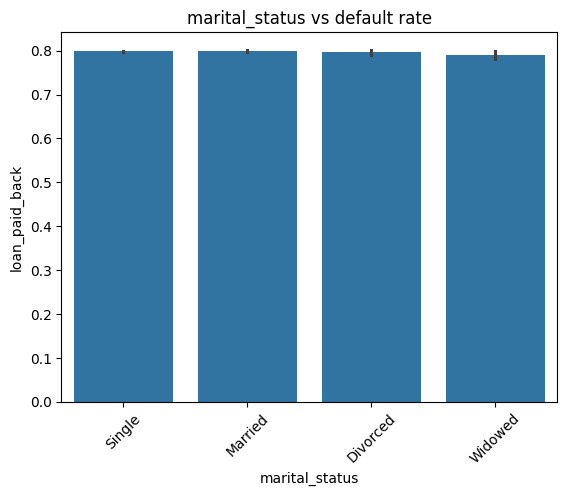

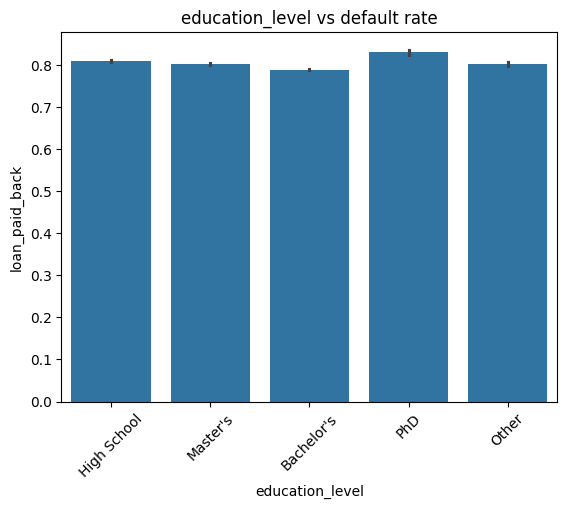

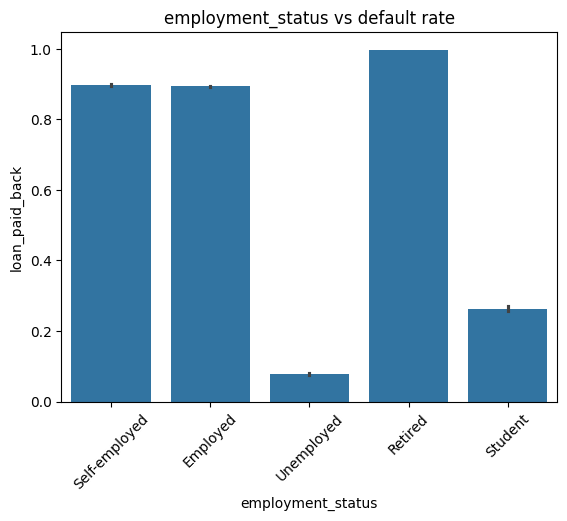

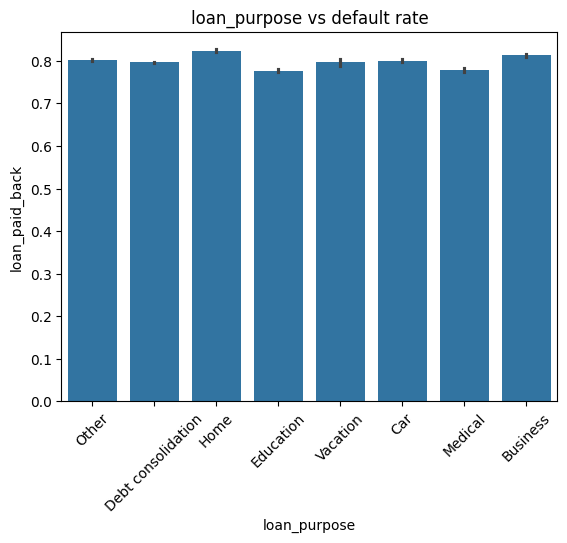

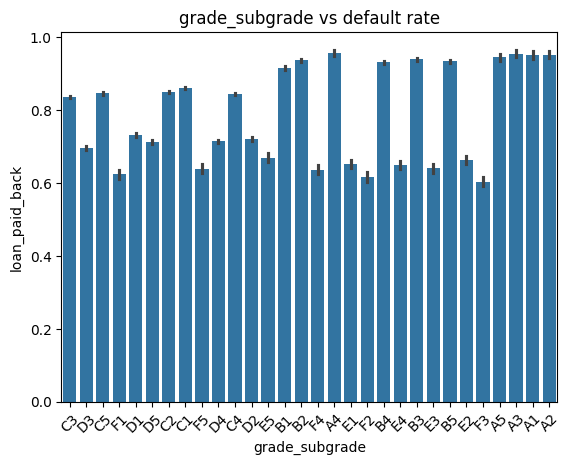

In [16]:
for col in categorical_features:
    sns.barplot(x=col, y="loan_paid_back", data=data)
    plt.xticks(rotation=45)
    plt.title(f"{col} vs default rate")
    plt.show()


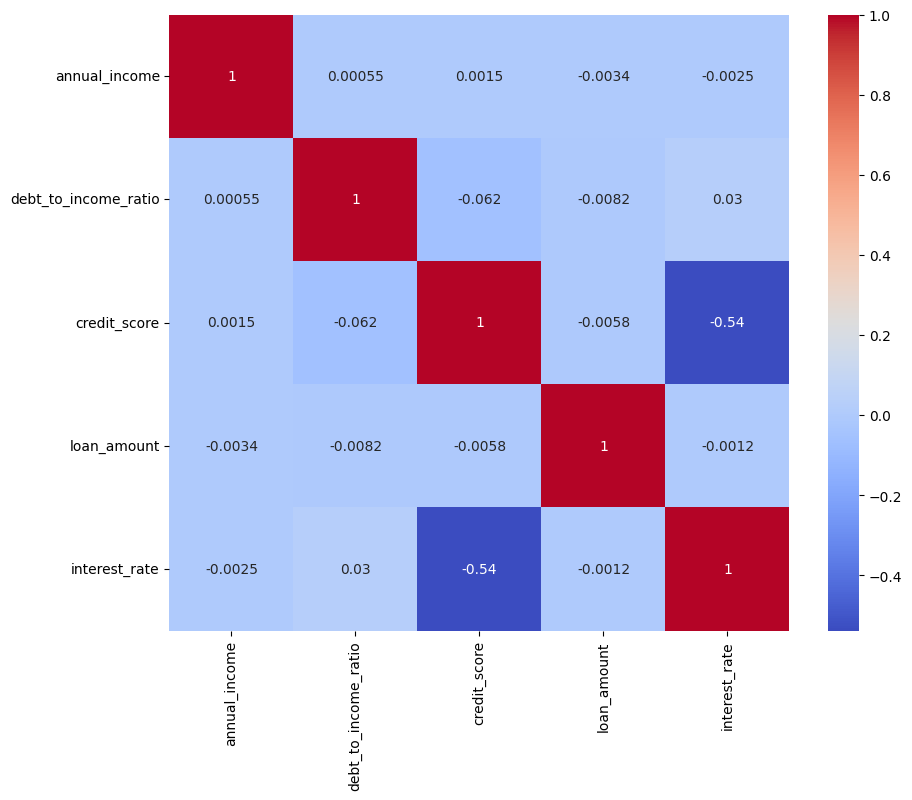

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap="coolwarm")
plt.show()

# Preprocessing

In [18]:
numeric_features = list(numeric_cols)
categorical_features = list(X_train.drop(columns=numeric_cols))

#scaling not needed for trees, so just one hot encoding
preprocessor_onehot = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

#No transformation for CatBoost
preprocessor_notransf = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", "passthrough", categorical_features)
])

#Only numerical encoding for CatBoost, XGBoost and LightGBM
preprocessor_standard = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", "passthrough", categorical_features)
])

#Use for: LogisticRegression, LinearSVC, SVM (rbf), MLPClassifier, etc.
preprocessor_standard_onehot = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

#MinMax could be better for KNN and maybe some neural nets
preprocessor_minmax_onehot = ColumnTransformer([
    ("num", MinMaxScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

#Use for: LogisticRegression / SVM when outliers are a problem.
preprocessor_robust_onehot = ColumnTransformer([
    ("num", RobustScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [19]:
#Ordinal encoding:
ordinal_features = ["education_level", "grade_subgrade"]
nominal_features = [col for col in categorical_features if col not in ordinal_features]

ordinal_categories = [
    ["Other", "High School", "Bachelor's", "Master's", "PhD"], # education
    ["A1","A2","A3","A4","A5",
     "B1","B2","B3","B4","B5",
     "C1","C2","C3","C4","C5",
     "D1","D2","D3","D4","D5",
     "E1","E2","E3","E4","E5",
     "F1","F2","F3","F4","F5",
     "G1","G2","G3","G4","G5"]                                # grade
]

ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

preprocessor_standard_ordinal = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("ord", OrdinalEncoder(), ordinal_features),
    ("nom", OneHotEncoder(handle_unknown='ignore'), nominal_features)
])

In [20]:
logit = Pipeline([
    ("preprocess", preprocessor_robust_onehot),
    ("clf", LogisticRegression(max_iter=500))
])

In [21]:
scores = cross_val_score(logit, X_train, y_train, cv=5, scoring="roc_auc")
print(scores.mean())
#preprocessor_standard_onehot : 0.9105427483633374
#preprocessor_robust_onehot : 0.910523361508049

0.9105005880808786


In [30]:
logit_smote = ImbPipeline([
    ("preprocess", preprocessor_robust_onehot),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=500))
])

In [31]:
scores = cross_val_score(logit_smote, X_train, y_train, cv=5, scoring="roc_auc")
print(scores.mean())
#preprocessor_standard_onehot : 0.9105427483633374
#preprocessor_robust_onehot : 0.910523361508049

0.9103697227713237


# Baseline logit training and submission.csv creation

In [22]:
logit.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'credit_score',
                                                   'loan_amount',
                                                   'interest_rate']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'marital_status',
                                                   'education_level',
                                                   'employment_status',
                                                   'loan_purpose',
                                                   'grade_subgrade'])])),
                ('clf', LogisticRegression(max_iter=500))])

In [23]:
y_pred = logit.predict_proba(data_test)[:, 1]

In [24]:
submission = pd.DataFrame({
    "id": data_test["id"],
    "loan_paid_back": y_pred
})

In [25]:
submission.to_csv("submission.csv", index=False)
#Score: 0.91096 / Private score: 0.91174 for preprocessor_standard_onehot